In [1]:
# imports 
import os
import time

import tensorflow as tf 
import cv2 
import numpy
from matplotlib import pyplot as plt
from jiwer import wer 
# making GPU be used, and setting memory limits
gpus = tf.config.list_physical_devices('GPU')
# gpus = tf.config.list_logical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("gpu set")
except:
    pass
    print("failed")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
gpu set


## basic functions

In [2]:
# setting up the functions to convert from chars to num and vice versa
vocab = [x for x in "ABCDEFGHIJKLMNOPQRSTUVWXYZ "]
charToNum = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
numToChar = tf.keras.layers.StringLookup(vocabulary=charToNum.get_vocabulary(), oov_token="", invert=True)

# facial detection vars 
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
lastKnownCrop = (0, 0, 160, 150)

# data dir
rootDir = 'A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles'
rootDir2 = 'A:\Lip Reading\Potential Datasets\\BBC LRS2'
# r = "A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles"

errorNums = 0 
errorPaths = []
errorInfo = []
frameSize = None
frameSizeOld = None
newFrameSize = None
grayFrame = None
newImageSize = (40, 120)

maxCharCt = 145 # found from the dataStats.ipynb
maxFrameCt = 2*maxCharCt

In [3]:
# util funcs 
def faceDetection(img):
    # TROUBLESHOOTING
    # print("max size:",img.shape, img.shape[0] - 3 * padding, img.shape[1] - 3 * padding)
    return faceCascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=5,
        minSize=(30, 30),
    )

def cropForMouth(img) -> numpy.ndarray:
    global lastKnownCrop
    rects = faceDetection(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    
    # finding the largest face in a given image 
    largestFace = (0,0,0,0)
    for (x, y, w, l) in rects:
        if (w * l) > largestFace[2] * largestFace[3]:
            largestFace = (x, y,w,l)
        
    if largestFace == (0,0,0,0):
        largestFace =lastKnownCrop
    # cropping for face 
    lastKnownCrop = largestFace
    y1 = lastKnownCrop[1] 
    x1 = lastKnownCrop[0]
    y2 = y1 + lastKnownCrop[3] 
    x2 = x1 + lastKnownCrop[2]
    return img[y1 + int(0.65 * lastKnownCrop[3]): y2, x1 + int(0.05 * lastKnownCrop[2]): int(0.95 * x2)]

def numberToWords(num):  
    if num == 0:  
        return "zero"  
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]  
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]  
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]  
    words = ""  
    if num>= 1000:  
        words += ones[num // 1000] + " thousand "  
        num %= 1000  
    if num>= 100:  
        words += ones[num // 100] + " hundred "  
        num %= 100  
    if num>= 10 and num<= 19:  
        words += teens[num - 10] + " "  
        num = 0  
    elif num>= 20:  
        words += tens[num // 10] + " "  
        num %= 10  
    if num>= 1 and num<= 9:  
        words += ones[num] + " "  
    return words.strip().upper()

In [4]:
def loadData(path): 
    # tf has the paths as bytes so decode that
    path = bytes.decode(path.numpy())
    
    # extract just the file names
    global rootDir
    fileName = path.split('\\')[-1].split('.')[0]
    # generate the respective paths of the data
    videoPath = os.path.join(rootDir,f'{fileName}.mp4')
    alignmentPath = os.path.join(rootDir,f'{fileName}.txt')
    
    # return the frames and alignments
    frames = loadVideo(videoPath) 
    alignments = loadText(alignmentPath)
    return frames, alignments

def loadVideo(path): 
    cap = cv2.VideoCapture(path)
    global lastKnownCrop, frameSizeOld, frameSize, newFrameSize, grayFrame
    global errorNums
    processedFrames = []
    isFirstFrame = True
    frameShape = None
    # for each frame 
    for n in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        
        # in case a frame is missing, just continue
        if frame is None or frame.shape[0] == 0: 
            continue
        
        if isFirstFrame: 
            frameShape  = frame.shape
            isFirstFrame = False
        
        if frame.shape != frameShape: 
            continue
        # crop only the mouth like we'll do on the RPI 
        frameSizeOld = frame.shape
        frame = cropForMouth(frame)
        frameSize = frame.shape
        frame = cv2.resize(frame, (newImageSize[1], newImageSize[0]))
        newFrameSize = frame.shape
        grayFrame = tf.image.rgb_to_grayscale(frame)
        processedFrames.append(grayFrame)
        # processedFrames = [*processedFrames, grayFrame]

    
    cap.release()    

    # generate the normalized frames (deviation from the average)
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)
    try: 
        std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32),  keepdims=True)
    except: 
        
        errorPaths.append(path)
        errorInfo.append("SECOND STATEMENT")
        errorInfo.append(len(processedFrames))
        errorInfo.append(frameSizeOld)
        errorInfo.append(frameSize)
        errorInfo.append(newFrameSize)
        errorInfo.append(grayFrame)
    std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32), keepdims=True)
    frames = tf.cast(processedFrames, tf.float32)
    normalizedFrames = (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / tf.cast(std, tf.float32)
    return normalizedFrames

def loadText(path): 
    # open and parse the file 
    with open(path, 'r') as file: lines = file.readlines()
    file.close()
    
    # return the number equivalent of each of the characters of the word 
    tokens = []
    words = lines[0].split()
    del words[0]

    for word in words: 
        if word.isnumeric():
            newWord = numberToWords(int(word))
            words[words.index(word)] = newWord
    words = " ".join(words).split()
    # print(words)
    for word in words: 
        tokens = [*tokens,' ', word]
    try:
        return charToNum(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]   
    except: 
        print(tokens)

def processData(path): 
    return tf.py_function(loadData, [path],  (tf.float32, tf.int64))

In [5]:
def getFrameCount(path) -> int: 
    cap = cv2.VideoCapture(path)
    frameCount = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return frameCount

def getCharCount(path) -> int: 
    return len(loadText(path))

In [6]:
# numberPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\Numbers.txt"
# tensorPath = tf.convert_to_tensor(numberPath, dtype=tf.string)
# path = bytes.decode(tensorPath.numpy())
# fileName = path.split('\\')[-1].split('.')[0]
# 
# # testing if the loadData, loadVideo, and loadText function all work
# alignmentPath = os.path.join(rootDir2,f'{fileName}.txt')
# loadText(alignmentPath)

In [7]:
rawPath = "A:\\Lip Reading\\Potential Datasets\\BBC LRS2\\allFiles\\5535415699068794046_00006.mp4"

tensorPath = tf.convert_to_tensor(rawPath, dtype=tf.string)
path = bytes.decode(tensorPath.numpy())
fileName = path.split('\\')[-1].split('.')[0]

# testing if the loadData, loadVideo, and loadText function all work
videoPath = os.path.join(rootDir,f'{fileName}.mp4')
alignmentPath = os.path.join(rootDir,f'{fileName}.txt')

loadVideo(videoPath)
loadText(alignmentPath)

frames, text = loadData(tensorPath)
print(type(frames))
print(frames)
print(len(frames[0][0]))

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[[[ 0.9325923 ]
   [ 0.97313976]
   [ 1.0947822 ]
   ...
   [-1.8651845 ]
   [-2.0273745 ]
   [-2.1490169 ]]

  [[ 0.8920448 ]
   [ 0.97313976]
   [ 1.0542347 ]
   ...
   [-1.8651845 ]
   [-2.0273745 ]
   [-2.1490169 ]]

  [[ 0.8920448 ]
   [ 0.9325923 ]
   [ 0.97313976]
   ...
   [-1.905732  ]
   [-2.0679219 ]
   [-2.1490169 ]]

  ...

  [[ 0.9325923 ]
   [ 0.8109498 ]
   [ 0.68930733]
   ...
   [-1.7029946 ]
   [-1.7029946 ]
   [-1.6624471 ]]

  [[ 0.8514973 ]
   [ 0.7704023 ]
   [ 0.68930733]
   ...
   [-1.7029946 ]
   [-1.6624471 ]
   [-1.7029946 ]]

  [[ 0.7298548 ]
   [ 0.68930733]
   [ 0.64875984]
   ...
   [-1.6218996 ]
   [-1.6624471 ]
   [-1.7029946 ]]]


 [[[ 0.8514973 ]
   [ 0.8920448 ]
   [ 0.97313976]
   ...
   [-1.4191622 ]
   [-1.6218996 ]
   [-1.7435421 ]]

  [[ 0.8514973 ]
   [ 0.9325923 ]
   [ 0.97313976]
   ...
   [-1.5002571 ]
   [-1.6624471 ]
   [-1.7840896 ]]

  [[ 0.8920448 ]
   [ 0.9325923 ]
   [

## reading data

In [18]:
# reading all files within the root directory
# data = tf.data.Dataset.list_files('A:\Lip Reading\Potential Datasets\BBC LRS2\mvlrs_v1\main\*\*.mp4')
data = tf.data.Dataset.list_files('A:/Lip Reading/Potential Datasets/BBC LRS2/allFiles2/*.mp4')
# data = tf.data.Dataset.list_files('A:/Lip Reading/Potential Datasets/BBC LRS2/trainFiles6/*.mp4')

global maxCharCt

data = data.shuffle(500, reshuffle_each_iteration=False) # shuffling data
data = data.map(processData) # "processing" the data to obtain frames and the respective text 

dim1 = newImageSize[0]
dim2 = newImageSize[1]
print("dataset size before padding:", len(data))
print("data shape of example frame:", newImageSize)
print("data shape of example video:", frames.shape)
print("dims: ",dim1, "x",dim2)

# combining 8 videos as one "input"
# ensuring all videos are padded to match the longest video, 
# ensuring the length of all the alignments is the size of the longest text characters, as some are lower. 
batchSize = 2
data = data.padded_batch(batchSize, padded_shapes=([maxFrameCt,None, None,None], [maxCharCt])) 
print("autotune: ",tf.data.AUTOTUNE)
data = data.prefetch(tf.data.AUTOTUNE)
# data=data.prefetch(3)
print("data length after padding:", len(data))
print("batch size:", batchSize)

train = data.take(int(len(data) * 0.6))
test = data.skip(int(len(data) * 0.6))
print("train data size:", len(train))
print("test data size:",  len(test))

dataset size before padding: 3783
data shape of example frame: (40, 120)
data shape of example video: (68, 40, 120, 1)
dims:  40 x 120
autotune:  -1
data length after padding: 1892
batch size: 2
train data size: 1135
test data size: 757


In [19]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 290, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 145), dtype=tf.int64, name=None))>

290


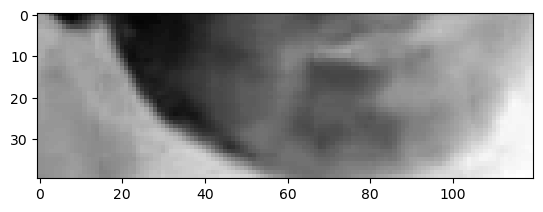

In [20]:
val = data.as_numpy_iterator().next()
plt.imshow(val[0][0][2], cmap='gray_r')
print(len(val[0][0]))

In [21]:
print(tf.strings.reduce_join([numToChar(word) for word in val[1][0]]))
print("num of chars:", len(([numToChar(word) for word in val[1][0]])))

tf.Tensor(b'THE IDEA OF FIXED', shape=(), dtype=string)
num of chars: 145


## designing the model

In [22]:
# imports for the model architecture 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPooling3D, TimeDistributed, Flatten, GRU
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [23]:
inputShape = data.as_numpy_iterator().next()[0][0].shape
print(inputShape)
print(charToNum.get_vocabulary())
print(len(charToNum.get_vocabulary()))

(290, 40, 120, 1)
['', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']
28


In [24]:
# model to be actually trained
def createModel(x): 
    model = Sequential([
    Conv3D(32, 3, input_shape=inputShape, padding='same', activation='relu', name="conv1"),
    MaxPooling3D((1,2,2), name="maxPool1"),
    
    Conv3D(64, 3, padding='same', activation='relu', name="conv2"),
    MaxPooling3D((1,2,2), name="maxPool2"),
        
    Conv3D(96, (2,3,3),  padding='same', activation='relu', name="conv3"),
    MaxPooling3D((1,2,2), name="maxPool3"),
    
    TimeDistributed(Flatten()),
    
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal', return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal', return_sequences=True)),
    Dropout(.5),

        
    # Bidirectional(LSTM(256, kernel_initializer='orthogonal' , return_sequences=True)),
    Bidirectional(GRU(x, kernel_initializer='orthogonal' , return_sequences=True)),
    Dropout(.5),
    
    Dense(charToNum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')
    ])
    return model
# model to be actually traine

In [25]:
model2 = createModel(128)
print("final model input shape:",  inputShape)
model2.summary()

final model input shape: (290, 40, 120, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 290, 40, 120, 32)  896       
                                                                 
 maxPool1 (MaxPooling3D)     (None, 290, 20, 60, 32)   0         
                                                                 
 conv2 (Conv3D)              (None, 290, 20, 60, 64)   55360     
                                                                 
 maxPool2 (MaxPooling3D)     (None, 290, 10, 30, 64)   0         
                                                                 
 conv3 (Conv3D)              (None, 290, 10, 30, 96)   110688    
                                                                 
 maxPool3 (MaxPooling3D)     (None, 290, 5, 15, 96)    0         
                                                                 
 time_distr

In [32]:
# custom functions 
def scheduler(epoch, lr):
    if epoch < 15:
        return lr        
    else:
        return lr * tf.math.exp(-0.05)
    
def scheduler2(epoch, lr):
    return lr * tf.math.exp(-0.1)
# custom loss function 
def CTCLoss(yTrue, yPred):
    # y true is the text alignment (None, 99) 
    # y pred is the end result of the model (154, 41) 
    batchLen = tf.cast(tf.shape(yTrue)[0], dtype="int64")

    inputLen = tf.cast(tf.shape(yPred)[1], dtype="int64")
    labelLen = tf.cast(tf.shape(yTrue)[1], dtype="int64")
    inputLen = inputLen * tf.ones(shape=(batchLen, 1), dtype="int64")
    labelLen = labelLen * tf.ones(shape=(batchLen, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(yTrue, yPred, inputLen, labelLen)   
    return loss 

class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        try: 
            data = self.dataset.next()
            yhat = self.model.predict(data[0])
            start = time.time()
       
            decoded = tf.keras.backend.ctc_decode(yhat, [maxFrameCt,maxFrameCt], greedy=False)[0][0].numpy()
            for x in range(len(yhat)):           
                print('Original:', tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'))
                print('Prediction:', tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8'))
                print("Word Error Rate: ", str(wer(tf.strings.reduce_join(numToChar(data[1][x])).numpy().decode('utf-8'), tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8') ) * 100) + "%")
                print('~'*100)
                print(time.time() - start)
        except: 
            pass     
      

In [33]:
def makePrediction(model, valuePassed=None): 
    if valuePassed is None: 
        value = val
    else: 
        value = valuePassed
    yHat = model.predict(value[0])
    
    decoded = tf.keras.backend.ctc_decode(yHat, [maxFrameCt, maxFrameCt], greedy=False)[0][0].numpy()
    originalArr = []
    predArr = []
    for x in range(len(yHat)):          
        original = tf.strings.reduce_join(numToChar(val[1][x])).numpy().decode('utf-8')
        prediction = tf.strings.reduce_join(numToChar(decoded[x])).numpy().decode('utf-8')
        originalArr.append(original)
        predArr.append(prediction )
        
        print('Original:', original)
        print('Prediction:', prediction)
        print("Word Error Rate on Prediction:", str(wer(original,prediction) * 100) + "%")
        print('~' * 40)
    print("Avg Word Error Rate:", str(wer(originalArr, predArr) * 100) + "%")
    
    return value, yHat, decoded

In [34]:
makePrediction(model2)

1/1 [==============================] - 0s 316ms/step
Original: THE IDEA OF FIXED
Prediction: T 
Word Error Rate on Prediction: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: WAITING IN THE WINGS ARE ENTREPRENEURS DESPERATE TO SECURE SOME CASH
Prediction:  E E
Word Error Rate on Prediction: 100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Avg Word Error Rate: 100.0%


((array([[[[[ 1.3176159 ],
            [ 1.9165323 ],
            [ 2.1161711 ],
            ...,
            [-0.23956653],
            [-0.2794943 ],
            [-0.3593498 ]],
  
           [[ 0.7985551 ],
            [ 1.477327  ],
            [ 1.8366767 ],
            ...,
            [-0.23956653],
            [-0.31942204],
            [-0.39927754]],
  
           [[ 0.2794943 ],
            [ 0.67877185],
            [ 1.2377604 ],
            ...,
            [-0.23956653],
            [-0.31942204],
            [-0.39927754]],
  
           ...,
  
           [[-0.07985551],
            [-0.07985551],
            [-0.19963877],
            ...,
            [-1.3974714 ],
            [-1.3974714 ],
            [-1.3974714 ]],
  
           [[-0.15971102],
            [-0.15971102],
            [-0.19963877],
            ...,
            [-1.4373991 ],
            [-1.4373991 ],
            [-1.4373991 ]],
  
           [[-0.07985551],
            [-0.15971102],
            

## compilign the model??

In [35]:
model2.compile(optimizer=Adam(learning_rate=0.0005), loss=CTCLoss)
# create all the callbacks 
checkpointCallback2 = ModelCheckpoint('newUpdatedModel/modifiedModelv1.weights.h5', monitor='loss',save_weights_only=False, save_freq='epoch') # save checkpoints after each epoch

scheduleCallback2 = LearningRateScheduler(scheduler)
exampleCallback2 = ProduceExample(test)

In [36]:
model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2, scheduleCallback2], use_multiprocessing=True)

Epoch 1/300
1/1 [==============================] - 1s 1s/step
Original: ONE COUPLE MUST LEAVE TONIGHT
Prediction: T E E E E E
Word Error Rate:  120.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.14231491088867188
Original: THERE IS A VERY CLOSE KNIT COMMUNITY
Prediction: I E E E E
Word Error Rate:  100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.14431476593017578
1135/1135 [==============================] - 1852s 2s/step - loss: 113.8402 - val_loss: 112.5107 - lr: 2.0000e-04
Epoch 2/300
1/1 [==============================] - 0s 106ms/step
Original: ABOVE ALL OTHERS
Prediction: T E
Word Error Rate:  100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.16151905059814453
Original: I WAS VERY KEEN TO GET INVOLVED
Prediction: T E E
Word Error Rate:  100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

KeyboardInterrupt: 

In [ ]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2], use_multiprocessing=True)

Epoch 1/300
   2/1135 [..............................] - ETA: 7:09 - loss: 69.3661   

In [ ]:
model2.load_weights('updatedModel_v1.weights.h5')

model2.compile(optimizer=Adam(learning_rate=0.00006), loss=CTCLoss)
# create all the callbacks 
checkpointCallback2 = ModelCheckpoint('updatedModel_v2.weights.h5', monitor='loss',save_weights_only=False, save_freq='epoch') # save checkpoints after each epoch
exampleCallback2 = ProduceExample(test)
scheduleCallback2 = LearningRateScheduler(scheduler)

model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2, scheduler2()], use_multiprocessing=True)

# finished with loss ~ 35

In [34]:
model2.compile(optimizer=Adam(learning_rate=0.00002), loss=CTCLoss)
# create all the callbacks 
checkpointCallback2 = ModelCheckpoint('updatedModel_v3.weights.h5', monitor='loss',save_weights_only=False, save_freq='epoch') # save checkpoints after each epoch
exampleCallback2 = ProduceExample(test)
scheduleCallback2 = LearningRateScheduler(scheduler)

model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2, scheduleCallback2], use_multiprocessing=True)

Epoch 1/300
1/1 [==============================] - 2s 2s/step
Original: THROUGHOUT THIS YEAR RACHEL HAS MADE FOR THE FIRST TIME A CUT FLOWER GARDEN AND KEPT A DIARY OF IT
Prediction: THROUGHOUT THIS YEAR RACHEL HAS MADE FOR THE FIRST TIME A CUT FLOWER GARDEN AND KEPT A DIARY OF IT
Word Error Rate:  0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: I ENJOY GOING TO GIGS
Prediction: I ENJOY GOING TO GIGS
Word Error Rate:  0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: OR YOU JUST FANCY HAVING A GO
Prediction: I I E I E ET
Word Error Rate:  100.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: I WOULD SAY IM OPTIMISTIC
Prediction: I WOULD SAY IM OPTIMISTIC
Word Error Rate:  0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
662/662 [======

KeyboardInterrupt: 

In [36]:
model2.compile(optimizer=Adam(learning_rate=0.000007), loss=CTCLoss)
# create all the callbacks 
checkpointCallback2 = ModelCheckpoint('updatedModel_v4.weights.h5', monitor='loss',save_weights_only=False, save_freq='epoch') # save checkpoints after each epoch
exampleCallback2 = ProduceExample(test)
scheduleCallback3 = LearningRateScheduler(scheduler2)

model2.fit(train, validation_data=test, epochs=300, callbacks=[checkpointCallback2, exampleCallback2, scheduleCallback3], use_multiprocessing=True)

Epoch 1/300
1/1 [==============================] - 1s 1s/step
Original: IT WAS A DECADE OF MASSIVE SOCIAL AND POLITICAL CHANGE BUT FOR THOSE OF US WHO LIVED THROUGH IT
Prediction: IE I E AD OF MASIVE SOCIAL AND POLITICAL CHANGE BUT FOR THOSE OF US WHO LIVED THROUGH IT
Word Error Rate:  26.31578947368421%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: WHEN IT COMES TO DESIGNING FABULOUS COSTUMES
Prediction: WHE IS O A O I IN T
Word Error Rate:  114.28571428571428%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: MARY AND JANE PARMENTER
Prediction: MARY AND JANE PARMENTER
Word Error Rate:  0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: WELCOME TO EGGHEADS
Prediction: WELCOME TO EGHEADS
Word Error Rate:  33.33333333333333%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

KeyboardInterrupt: 

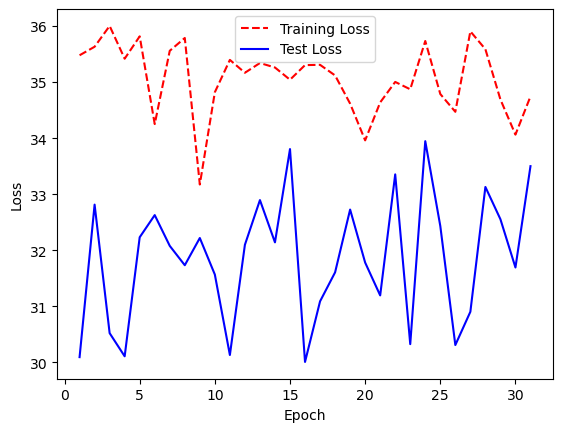

In [37]:
# Get training and test loss histories
training_loss = model2.history.history['loss']
test_loss = model2.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [38]:
value, yHat, decoded = makePrediction(model2)

1/1 [==============================] - 1s 549ms/step
Original: THEY THINK I SWAN ROUND MAYFAIR SPENDING RICH PEOPLES MONEY
Prediction: THEY THINK I SWAN ROUND MAYFAIR SPENDING RICH PEOPLES MONEY
Word Error Rate on Prediction: 0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: HE WAS VERY HAPPY
Prediction: HE WAS VERY HAPY
Word Error Rate on Prediction: 25.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: DO I HAVE A MOBILE
Prediction: YO I HAVE A MOBILE
Word Error Rate on Prediction: 20.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: CHRIS IS STAYING IN AUSTRALIA
Prediction: TE A E O A E
Word Error Rate on Prediction: 120.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Avg Word Error Rate: 33.33333333333333%


In [111]:
val[0][0].shape

(290, 40, 120, 1)

In [198]:
def padTensor(tensor, target_shape, padding_value=0):
  """Pads a tensor to the specified target shape with a given padding value.

  Args:
      tensor: The tensor to be padded.
      target_shape: The desired padded shape.
      padding_value: The value to use for padding (default: 0).

  Returns:
      The padded tensor.
  """

  paddings = [[0, target_shape[0] - tensor.shape[0]],  # Pad leading and trailing dimensions 0
             [0, target_shape[1] - tensor.shape[1]],  # for the first 3 dimensions
             [0, target_shape[2] - tensor.shape[2]],
             [0, target_shape[3] - tensor.shape[3]]]  # Pad only for dimension 3
  return tf.pad(tensor, paddings, constant_values=padding_value)
  
def fixPath(path): 
    return path.replace('\\', '\\\\')
  

In [241]:
def loadData2(fileName): 
    # tf has the paths as bytes so decode that
 
    # generate the respective paths of the data
    vidName = fileName + (".mp4")
    txtName = fileName + (".txt")
    print(vidName)
    videoPath = os.path.join(rootDir2, "customVids", vidName)
    alignmentPath = os.path.join(rootDir2, "customVids", txtName)
    
    # return the frames and alignments
    frames = loadVideo(videoPath) 
    alignments = loadText(alignmentPath)
    return frames, alignments

def loadVideo2(path, ): 
    cap = cv2.VideoCapture(path)
    global lastKnownCrop, frameSizeOld, frameSize, newFrameSize, grayFrame
    global errorNums, maxFrameCt
    processedFrames = []
    isFirstFrame = True
    frameShape = None
    frameCount = 0
    
    # for each frame 
    for n in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        if frameCount != maxFrameCt:
            ret, frame = cap.read()
            
            # in case a frame is missing, just continue
            if frame is None or frame.shape[0] == 0: 
                continue
            
            if isFirstFrame: 
                frameShape  = frame.shape
                isFirstFrame = False
            
            if frame.shape != frameShape: 
                continue
            # crop only the mouth like we'll do on the RPI 
            frameSizeOld = frame.shape
            frame = cropForMouth(frame)
            frameSize = frame.shape
            frame = cv2.resize(frame, (newImageSize[1], newImageSize[0]))
            newFrameSize = frame.shape
            try: 
                grayFrame = tf.image.rgb_to_grayscale(frame)
            except: 
                continue
            processedFrames.append(grayFrame)
            # processedFrames = [*processedFrames, grayFrame]
            lastFrame = grayFrame
            frameCount += 1

    while len(processedFrames) < maxFrameCt: 
        processedFrames.append(lastFrame)
    cap.release()    

    # generate the normalized frames (deviation from the average)
    mean = tf.math.reduce_mean(processedFrames, keepdims=True)
    try: 
        std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32),  keepdims=True)
    except: 
        
        errorPaths.append(path)
        errorInfo.append("SECOND STATEMENT")
        errorInfo.append(len(processedFrames))
        errorInfo.append(frameSizeOld)
        errorInfo.append(frameSize)
        errorInfo.append(newFrameSize)
        errorInfo.append(grayFrame)
    std = tf.math.reduce_std(tf.cast(processedFrames, tf.float32), keepdims=True)
    frames = tf.cast(processedFrames, tf.float32)
    normalizedFrames = (tf.cast(frames, tf.float32) - tf.cast(mean, tf.float32)) / tf.cast(std, tf.float32)
    return normalizedFrames

def makePredictionOnVid(path, model):
    sample = loadData(tf.convert_to_tensor(path))
    print('~'*60)
    original = tf.strings.reduce_join(numToChar(sample[1])).numpy().decode('utf-8')
    paddedVid =  padTensor(sample[0], (290, 40, 120, 1))
    yhat = model.predict(tf.expand_dims(paddedVid, axis=0))
    
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[maxFrameCt], greedy=True)[0][0].numpy()
    prediction = tf.strings.reduce_join(numToChar(decoded[0])).numpy().decode('utf-8')
    print('Original:', original)
    print('Prediction:', prediction)
    print("Word Error Rate on Prediction:", str(wer(original,prediction) * 100) + "%")

def makePredictionCustomVid(path, model): 
    sample = loadData2((path))
    original = tf.strings.reduce_join(numToChar(sample[1])).numpy().decode('utf-8')
    paddedVid =  padTensor(sample[0], (290, 40, 120, 1))
    yhat = model.predict(tf.expand_dims(paddedVid, axis=0))
    
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[maxFrameCt], greedy=True)[0][0].numpy()
    prediction = tf.strings.reduce_join(numToChar(decoded[0])).numpy().decode('utf-8')
    print('Original:', original)
    print('Prediction:', prediction)
    print("Word Error Rate on Prediction:", str(wer(original,prediction) * 100) + "%")

In [248]:
makePredictionCustomVid("5570920046221178499_00015", model2)

path = "A:\Lip Reading\Potential Datasets\BBC LRS2\\allFiles\\5570920046221178499_00015.mp4"
makePredictionOnVid(path, model2)

5570920046221178499_00015.mp4
1/1 [==============================] - 0s 389ms/step
Original: WHICH OF OUR CONTESTANTS TODAY IS GOING TO MAKE A THUMPING GREAT PROFIT
Prediction: WHICH OF OUR CONTESTANTS TODAY IS GOING TO MAKE A THUMPING GREAT PROFIT
Word Error Rate on Prediction: 0.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 77ms/step
Original: WHICH OF OUR CONTESTANTS TODAY IS GOING TO MAKE A THUMPING GREAT PROFIT
Prediction: WHICH OF OUR CONTESTANTS TODAY IS GOING TO MAKE A THUMPING GREAT PROFIT
Word Error Rate on Prediction: 0.0%


In [40]:
model2.save('finalModelMOREDATA.h5')
tf.saved_model.save(model2, 'finalModelMOREDATA')

INFO:tensorflow:Assets written to: finalModelMOREDATA\assets


INFO:tensorflow:Assets written to: finalModelMOREDATA\assets


In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_new_converter=True
tflite_model = converter.convert()

# Save the model.
with open('finalModelMOREDATA.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\monis\AppData\Local\Temp\tmpy067d2og\assets


INFO:tensorflow:Assets written to: C:\Users\monis\AppData\Local\Temp\tmpy067d2og\assets
